In [46]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

sys.path.append("../")

from fwc2.model import FWC2, FWC2V2
from fwc2.loss import NTXent
from fwc2.dataset import load, preprocess, load_pretraining, FWC2Dataset

SEED = 42

# Pretraining
Here we load the pretrainig data, apply simple preprocessing to data (normalization) and then train the model

In [48]:
df = load('dapt20')

['all.csv'] 1
all.csv shape of data = (86690, 86)


In [49]:
df = preprocess(df, pretraining=True)

selected featurs = Index(['flow_duration', 'total_fwd_packets', 'total_backward_packets',
       'total_length_of_fwd_packets', 'total_length_of_bwd_packets',
       'fwd_packet_length_max', 'fwd_packet_length_min',
       'fwd_packet_length_mean', 'fwd_packet_length_std',
       'bwd_packet_length_max', 'bwd_packet_length_min',
       'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_bytes/s',
       'flow_packets/s', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_max',
       'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std',
       'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean',
       'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'bwd_psh_flags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',
       'ack_flag_count',

In [50]:
df

,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,...,act_data_pkt_fwd,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,119998944.0,242.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000e+00,0.00000,0.0,0.0,0.00,0.000000e+00,0.0,0.0,benign
1,109235816.0,21.0,1.0,1072.0,52.0,56.0,48.0,51.047619,2.499524,52.0,...,21.0,8.195355e+05,78517.84409,875056.0,764015.0,15175318.57,6.349189e+06,20019201.0,5202524.0,benign
2,119764062.0,88.0,1.0,25515.0,289.0,296.0,288.0,289.943182,2.422870,289.0,...,88.0,0.000000e+00,0.00000,0.0,0.0,0.00,0.000000e+00,0.0,0.0,benign
3,117030424.0,18.0,17.0,23499.0,3736.0,4096.0,0.0,1305.500000,1551.616283,929.0,...,10.0,1.923293e+05,436593.12330,1083374.0,7236.0,19311305.17,1.177830e+07,34978598.0,5147962.0,benign
4,119999703.0,2.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000e+00,0.00000,0.0,0.0,59999851.50,8.478210e+02,60000451.0,59999252.0,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86685,15048093.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,7.016021e+06,0.00000,7016021.0,7016021.0,8032072.00,0.000000e+00,8032072.0,8032072.0,benign
86686,15058240.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,7.028311e+06,0.00000,7028311.0,7028311.0,8029929.00,0.000000e+00,8029929.0,8029929.0,benign
86687,15039436.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,7.019672e+06,0.00000,7019672.0,7019672.0,8019764.00,0.000000e+00,8019764.0,8019764.0,benign
86688,15054694.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,7.031059e+06,0.00000,7031059.0,7031059.0,8023635.00,0.000000e+00,8023635.0,8023635.0,benign


In [51]:
x, y = df.drop(columns=['label']), df['label']

x.shape, y.shape 

((82577, 64), (82577,))

In [9]:
pretrain_x, rest_x, pretrain_y, rest_y = train_test_split(x, y, test_size=0.5, random_state=SEED, shuffle=True, stratify=y)

In [52]:
pretrain_x.shape, rest_x.shape

((41288, 64), (41289, 64))

In [53]:
pretrain_y.value_counts(), rest_y.value_counts()

(label
 benign                30956
 reconnaissance         5954
 establish foothold     4302
 lateral movement         68
 data exfiltration         8
 Name: count, dtype: int64,
 label
 benign                30956
 reconnaissance         5955
 establish foothold     4302
 lateral movement         69
 data exfiltration         7
 Name: count, dtype: int64)

## Pretrain

In [54]:
train_x, val_x, train_y, val_y = train_test_split(pretrain_x, pretrain_y, test_size=0.2, shuffle=True, random_state=SEED, stratify=pretrain_y)

scaler = StandardScaler()

train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
val_x = pd.DataFrame(scaler.fit_transform(val_x), columns=val_x.columns)

train_ds = FWC2Dataset(train_x.to_numpy(), train_x.to_numpy(), columns=train_x.columns)
val_ds = FWC2Dataset(val_x.to_numpy(), val_y.to_numpy(), columns=val_x.columns)

In [16]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def step(self, loss):
        if self.best_loss is None or loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def train_epoch(model, criterion, train_loader, optimizer, device):
    model.train()
    epoch_loss = 0.0

    for x in train_loader:
        x = x.to(device)
        z_i, z_j = model(x)
        
        loss = criterion(z_i, z_j)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader.dataset)

def train(model, optimizer, loss, dataloader, val_dataloader, epochs, patience, device):
    early_stopping = EarlyStopping(patience=patience)
    
    loss_history = []
    val_loss_history = []
    
    for epoch in range(1, epochs + 1):
        loss = train_epoch(model, loss, dataloader, optimizer, device)
        loss_history.append(loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x in val_dataloader:
                x = x.to(device)
                z_i, z_j = model(x)
                val_loss += loss(z_i, z_j).item()
        val_loss /= len(val_dataloader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch} / {epochs} - loss: {loss}, val Loss: {val_loss}")
        
        early_stopping.step(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

In [59]:
batch_size = 128
max_epochs = 1000
corruption_rate = 0.4
tau = 1.0
device = 'cpu'

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

train_loader.dataset.shape[1]

64

In [18]:
batch_size = 128
max_epochs = 1000
corruption_rate = 0.4
tau = 1.0
device = 'cpu'

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

model = FWC2(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dims_hidden_encoder=[256, 256, 256, 256],
    dims_hidden_head=[64, 64],
    corruption_rate=corruption_rate,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
ntxent_loss = NTXent(tau)

loss_history = []

for epoch in range(1, max_epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    print(f"epoch {epoch}/{max_epochs} - loss: {loss_history[-1]:.4f}")

epoch 1/1000 - loss: 0.0434
epoch 2/1000 - loss: 0.0434
epoch 3/1000 - loss: 0.0433
epoch 4/1000 - loss: 0.0428
epoch 5/1000 - loss: 0.0426


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

fig.savefig(f'pretraining-loss--whp(cp={corruption_rate},tau={tau}).svg', format='svg')

## Fine Tuning

## Evaluation

## Traing a supervsied mlp

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=SEED, stratify=y_train_val
)

In [32]:
scaler = StandardScaler()
encoder = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)
y_test = encoder.fit_transform(y_test)

array([[ 2.38326767,  0.07935836, -0.0153714 , ..., -0.2310504 ,
        -0.35932048, -0.30272774],
       [-0.49441038, -0.02142229, -0.01517254, ..., -0.2310504 ,
        -0.35932048, -0.30272774],
       [-0.49400778, -0.02142229, -0.01497367, ..., -0.2310504 ,
        -0.35932048, -0.30272774],
       ...,
       [-0.1581505 ,  0.04111748,  0.00531056, ..., -0.2310504 ,
        -0.35932048, -0.30272774],
       [-0.48917639, -0.01783721, -0.01417821, ..., -0.2310504 ,
        -0.35932048, -0.30272774],
       [-0.49429853, -0.02142229, -0.01497367, ..., -0.2310504 ,
        -0.35932048, -0.30272774]])

In [45]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

In [40]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

(torch.Size([57803, 64]), torch.Size([57803]))

In [36]:
from fwc2.model import MLP

batch_size = 128
max_epochs = 1000
corruption_rate = 0.4
tau = 1.0
device = 'cpu'

in_dim = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

model = MLP(
        input_dim=in_dim,
        hidden_dims=[256, ]
    ).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
ntxent_loss = NTXent(tau)

loss_history = []

for epoch in range(1, max_epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    print(f"epoch {epoch}/{max_epochs} - loss: {loss_history[-1]:.4f}")

TypeError: MLP.__init__() missing 2 required positional arguments: 'input_dim' and 'hidden_dims'

In [ ]:
def train_epoch(model, criterion, train_loader, optimizer, device):
    model.train()
    epoch_loss = 0.0

    for x in train_loader:
        x = x.to(device)
        z_i, z_j = model(x)
        
        loss = criterion(z_i, z_j)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader.dataset)

def train(model, optimizer, loss, dataloader, val_dataloader, epochs, patience, device):
    early_stopping = EarlyStopping(patience=patience)
    
    loss_history = []
    val_loss_history = []
    
    for epoch in range(1, epochs + 1):
        loss = train_epoch(model, loss, dataloader, optimizer, device)
        loss_history.append(loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x in val_dataloader:
                x = x.to(device)
                z_i, z_j = model(x)
                val_loss += loss(z_i, z_j).item()
        val_loss /= len(val_dataloader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch} / {epochs} - loss: {loss}, val Loss: {val_loss}")
        
        early_stopping.step(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

In [2]:
v1_encoder_hidden_dims = [64, 32, 16, 8]
v1_project_hidden_dims = [16, 16]

v2_encoder_hidden_dims = [64, 128, 64, 32]
v2_project_hidden_dims = [16, 16]

model1 = FWC2(
    input_dim=68,
    features_low=0,
    features_high=0,
    dims_hidden_encoder=v1_encoder_hidden_dims,
    dims_hidden_head=v1_project_hidden_dims,
    corruption_rate=0.4,
    dropout=0.1,
)

model2 = FWC2V2(
    input_dim=68,
    features_low=0,
    features_high=0,
    dims_hidden_encoder=v2_encoder_hidden_dims,
    dims_hidden_head=v2_project_hidden_dims,
    corruption_rate=0.4,
    dropout=0.1,
)

model1.load_state_dict(torch.load('../output/kaggle/fwc2--whp(cp=0.4,tau=1.0).pt', map_location=torch.device('cpu') ))
model2.load_state_dict(torch.load('../output/kaggle/fwc2-v2--whp(cp=0.4,tau=0.5).pt', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [ ]:
for name, param in model1.named_parameters():
    
    # if name[5] < '2': 
    #     param.requires_grad = False

e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
e
a
a
a
a
a
a
a
a
a
a


In [29]:
np.random.seed(SEED)

sample_size = 10_000
sample_idx = np.random.choice(test_x.shape[0], sample_size, replace=False)

sample_x = test_x.iloc[sample_idx]
sample_y = test_y.iloc[sample_idx]

sample_y_binary = sample_y.apply(lambda x: 0 if x == 'benign' else 1)

sample_x.shape , sample_y.shape

((10000, 68), (10000,))

In [30]:
sample_y.value_counts(), sample_y_binary.value_counts()

(label
 benign                      5535
 dos hulk                    1799
 portscan                    1277
 ddos                        1063
 dos goldeneye                 90
 ftp-patator                   62
 ssh-patator                   49
 dos slowloris                 45
 dos slowhttptest              44
 bot                           17
 web attack   brute force      10
 web attack   xss               8
 infiltration                   1
 Name: count, dtype: int64,
 label
 0    5535
 1    4465
 Name: count, dtype: int64)

In [31]:
from sklearn.manifold import TSNE
import seaborn as sns

x_tensor = torch.tensor(sample_x.values, dtype=torch.float32)
x_emb_v1 = model1.get_embeddings(x_tensor)
x_emb_v2 = model2.get_embeddings(x_tensor)

n_componets = 2
tsne = TSNE(n_components=n_componets)
tsne_original = tsne.fit_transform(x_tensor)
tsne_v1_result = tsne.fit_transform(x_emb_v1)
tsne_v2_result = tsne.fit_transform(x_emb_v2)

tsne_result_original_df = pd.DataFrame({
    'tsne_1': tsne_original[:, 0],
    'tsne_2': tsne_original[:, 1],
    'label': sample_y_binary,
})

tsne_result_v1_df = pd.DataFrame({
    'tsne_1': tsne_v1_result[:, 0],
    'tsne_2': tsne_v1_result[:, 1],
    'label': sample_y_binary,
})

tsne_result_v2_df = pd.DataFrame({
    'tsne_1': tsne_v2_result[:, 0],
    'tsne_2': tsne_v2_result[:, 1],
    'label': sample_y_binary,
})

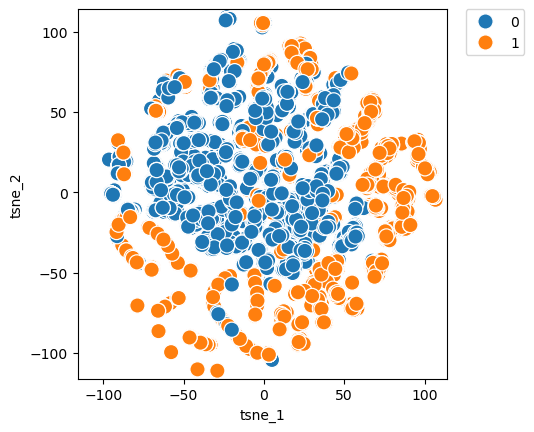

In [32]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_original_df, ax=ax,s=120)
lim = (tsne_original.min()-5, tsne_original.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

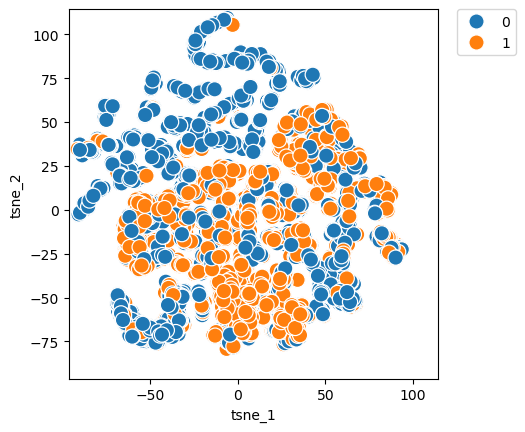

In [33]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_v1_df, ax=ax,s=120)
lim = (tsne_v1_result.min()-5, tsne_v1_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

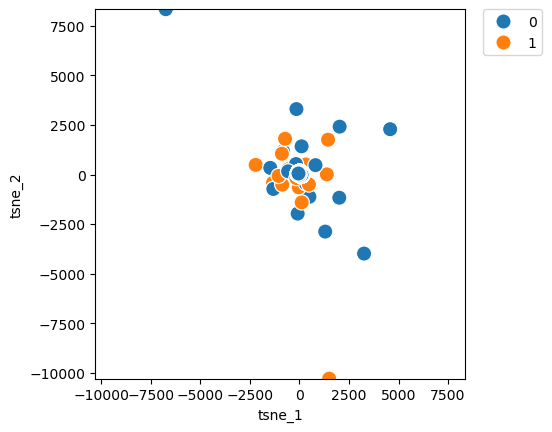

In [34]:
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_v2_df, ax=ax,s=120)
lim = (tsne_v2_result.min()-5, tsne_v2_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


In [69]:
# tensor = torch.tensor(])
# 

x = torch.tensor(test_x.iloc[0], dtype=torch.float32)
corruption_mask = torch.rand_like(x, device=x.device) > 0.9
anchor_mask = ~corruption_mask

corruption_mask, anchor_mask, torch.rand_like(x, device=x.device)

C:\Users\client\AppData\Local\Temp\ipykernel_23208\2015314030.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(test_x.iloc[0], dtype=torch.float32)


(tensor([False, False, False, False, False,  True, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
          True, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False]),
 tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         False,  True,  True,  True,  True,  True,  True,  True, False,  True,
          True,  True,  True,  True,  True, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,

In [71]:
torch.rand(1, 68)

tensor([[0.3412, 0.3553, 0.3977, 0.3256, 0.2371, 0.9740, 0.2302, 0.5347, 0.0713,
         0.2189, 0.7605, 0.5423, 0.7927, 0.4544, 0.0044, 0.5092, 0.5703, 0.4088,
         0.5638, 0.7947, 0.5114, 0.7125, 0.2979, 0.6287, 0.8715, 0.3193, 0.4918,
         0.9241, 0.6070, 0.1002, 0.6433, 0.5958, 0.3394, 0.5022, 0.3998, 0.9293,
         0.1360, 0.2390, 0.6340, 0.5261, 0.2036, 0.7910, 0.4226, 0.2751, 0.8188,
         0.7562, 0.2491, 0.4958, 0.9657, 0.4363, 0.8161, 0.9911, 0.0781, 0.6429,
         0.3829, 0.5908, 0.3144, 0.7062, 0.7619, 0.5045, 0.1940, 0.7108, 0.2982,
         0.7956, 0.7952, 0.7113, 0.5560, 0.4976]])